<a href="https://colab.research.google.com/github/ankan-mazumdar/End-to-End-Multi-AI-Agents-RAG-With-LangGraph-AstraDB-And-Llama-3.1/blob/main/3_Langraph_With_Astradb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install langchain langgraph cassio

In [ ]:
import cassio
## connection of the ASTRA DB
ASTRA_DB_APPLICATION_TOKEN="XXXX"
ASTRA_DB_ID="XXXX" 


In [3]:

cassio.init(token=ASTRA_DB_APPLICATION_TOKEN,database_id=ASTRA_DB_ID)

In [4]:
!pip install langchain_community

In [5]:
!pip install -U langchain_community tiktoken langchain-groq langchainhub chromadb langchain langgraph langchain_huggingface

In [6]:
### Build Index

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma


### from langchain_cohere import CohereEmbeddings



# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)



USER_AGENT environment variable not set, consider setting it to identify your requests.


In [7]:
docs_list

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [8]:
from dotenv import load_dotenv

# Load the .env file
load_dotenv()

True

In [9]:
!pip install sentence_transformers

In [10]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

c:\Users\somal\anaconda3\envs\multiai2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
from langchain.vectorstores.cassandra import Cassandra
astra_vector_store=Cassandra(
    embedding=embeddings,
    table_name="qa_mini_demo",
    session=None,
    keyspace=None

)

c:\Users\somal\anaconda3\envs\multiai2\lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [12]:
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
astra_vector_store.add_documents(doc_splits)
print("Inserted %i headlines." % len(doc_splits))

astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store)

c:\Users\somal\anaconda3\envs\multiai2\lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Inserted 88 headlines.


In [13]:
retriever=astra_vector_store.as_retriever()

In [15]:
retriever.invoke("What is agent",ConsistencyLevel="LOCAL_ONE")

c:\Users\somal\anaconda3\envs\multiai2\lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[Document(id='8a8177ab64484d0c84955da5e39fadf9', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context lear

In [16]:
from langchain.prompts import PromptTemplate

In [17]:
# Prompt template for generating a synthetic query
synthetic_query_prompt = PromptTemplate.from_template(
    "Given the following document, generate a question that this document can best answer:\n\n{document_text}\n\nQuestion:"
)
synthetic_query_prompt

PromptTemplate(input_variables=['document_text'], input_types={}, partial_variables={}, template='Given the following document, generate a question that this document can best answer:\n\n{document_text}\n\nQuestion:')

In [18]:
embeddings

HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2', cache_folder=None, model_kwargs={}, encode_kwargs={}, query_encode_kwargs={}, multi_process=False, show_progress=False)

In [20]:
from langchain.schema import Document
# Cosine similarity function
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Generate synthetic question for a document
def get_synthetic_query(document: Document):
    prompt = synthetic_query_prompt.format(document_text=document.page_content)
    response = llm.invoke(prompt)
    return response.content.strip()

In [21]:
### Router

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field



# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "wiki_search"] = Field(
        ...,
        description="Given a user question choose to route it to wikipedia or a vectorstore.",
    )

# from google.colab import userdata
# LLM with function call
from langchain_groq import ChatGroq
import os
groq_api_key=os.getenv('groq_api_key')
os.environ["GROQ_API_KEY"]=groq_api_key
llm=ChatGroq(groq_api_key=groq_api_key,model_name="llama-3.3-70b-versatile")
llm

c:\Users\somal\anaconda3\envs\multiai2\lib\site-packages\IPython\core\interactiveshell.py:3579: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000023C78AE3970>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000023C78AE14B0>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [22]:

structured_llm_router = llm.with_structured_output(RouteQuery)


In [23]:

# Prompt
system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use wiki-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router

In [24]:

print(
    question_router.invoke(
        {"question": "who is Sharukh Khan?"}
    )
)
print(question_router.invoke({"question": "What are the types of agent memory?"}))

datasource='wiki_search'
datasource='vectorstore'


In [25]:
!pip install langchain_community
!pip install arxiv wikipedia

In [26]:
### Working With Tools
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

## Arxiv and wikipedia Tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=200)
arxiv=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper)

In [27]:
## Graph

from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [44]:
from langchain.schema import Document


# HyQE-style retrieve function
def retrieve(state):
    """
    Retrieve documents with HyQE reranking using ChatGroq LLaMA 3.3 70B.

    Args:
        state (dict): Current RAG graph state.

    Returns:
        dict: Updated state with top reranked 'documents' and original 'question'.
    """
    print("---RETRIEVE (HyQE with ChatGroq)---")
    question = state["question"]

    # Step 1: Retrieve top-k documents
    initial_docs = retriever.invoke(question)

    # Step 2: Embed the real user query
    question_embedding = embeddings.embed_query(question)

    reranked_docs = []
    for doc in initial_docs:
        try:
            # Generate a synthetic query for this document
            synthetic_q = get_synthetic_query(doc)

            # Embed the synthetic query
            synthetic_q_embedding = embeddings.embed_query(synthetic_q)

            # Score similarity
            similarity = cosine_similarity(question_embedding, synthetic_q_embedding)
            reranked_docs.append((doc, similarity))
        except Exception as e:
            print(f"Error processing doc: {e}")
            continue

    # Step 3: Sort by similarity
    reranked_docs.sort(key=lambda x: x[1], reverse=True)
    top_docs = [doc for doc, _ in reranked_docs[:5]]  # Top N docs (tuneable)

    return {"documents": top_docs, "question": question}

In [45]:
from langchain.schema import Document

def wiki_search(state):
    """
    Wikipedia search with HyQE-style reranking using ChatGroq LLaMA 3.3 70B.

    Args:
        state (dict): The current graph state.

    Returns:
        dict: Updated state with top reranked Wikipedia documents.
    """
    print("---WIKIPEDIA (HyQE style)---")
    question = state["question"]
    print("Query:", question)

    # Step 1: Wikipedia search
    docs = wiki.invoke({"query": question})

    # Step 2: Wrap if it's just a string or one long block
    if isinstance(docs, str):
        docs = [Document(page_content=docs)]
    elif isinstance(docs, Document):
        docs = [docs]
    elif isinstance(docs, list):
        docs = [Document(page_content=doc) if isinstance(doc, str) else doc for doc in docs]

    # Step 3: Embed original question
    question_embedding = embeddings.embed_query(question)

    reranked_docs = []
    for doc in docs:
        try:
            # Generate a synthetic question the doc can answer
            synthetic_q = get_synthetic_query(doc)

            # Embed the synthetic question
            synthetic_q_embedding = embeddings.embed_query(synthetic_q)

            # Compute similarity
            similarity = cosine_similarity(question_embedding, synthetic_q_embedding)
            reranked_docs.append((doc, similarity))
        except Exception as e:
            print(f"Error processing wiki doc: {e}")
            continue

    # Step 4: Sort and select top N
    reranked_docs.sort(key=lambda x: x[1], reverse=True)
    top_docs = [doc for doc, _ in reranked_docs[:3]]  # Top 3 (or tune as needed)

    return {"documents": top_docs, "question": question}


In [46]:
### Edges ###


def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [47]:
### Edges ###


def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [48]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)
# Define the nodes
workflow.add_node("wiki_search", wiki_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge( "retrieve", END)
workflow.add_edge( "wiki_search", END)
# Compile
app = workflow.compile()

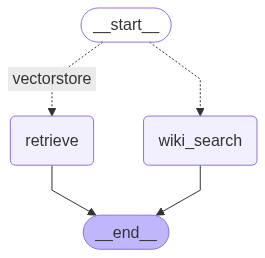

In [49]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [50]:
from pprint import pprint
import numpy as np

# Run
inputs = {
    "question": "What is agent?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'][0].dict()['metadata']['description'])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE (HyQE with ChatGroq)---


c:\Users\somal\anaconda3\envs\multiai2\lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\somal\anaconda3\envs\multiai2\lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\somal\anaconda3\envs\multiai2\lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\somal\anaconda3\envs\multiai2\lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  retur

"Node 'retrieve':"
'\n---\n'
('Building agents with LLM (large language model) as its core controller is a '
 'cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer '
 'and BabyAGI, serve as inspiring examples. The potentiality of LLM extends '
 'beyond generating well-written copies, stories, essays and programs; it can '
 'be framed as a powerful general problem solver.\n'
 'Agent System Overview\n'
 'In a LLM-powered autonomous agent system, LLM functions as the agent’s '
 'brain, complemented by several key components:\n'
 '\n'
 'Planning\n'
 '\n'
 'Subgoal and decomposition: The agent breaks down large tasks into smaller, '
 'manageable subgoals, enabling efficient handling of complex tasks.\n'
 'Reflection and refinement: The agent can do self-criticism and '
 'self-reflection over past actions, learn from mistakes and refine them for '
 'future steps, thereby improving the quality of final results.\n'
 '\n'
 '\n'
 'Memory\n'
 '\n'
 'Short-term memory: I wo

c:\Users\somal\anaconda3\envs\multiai2\lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
C:\Users\somal\AppData\Local\Temp\ipykernel_53256\3625012930.py:17: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  pprint(value['documents'][0].dict()['metadata']['description'])


In [52]:
from pprint import pprint
import numpy as np

# Run
inputs = {
    "question": "Who is Obama"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'])

---ROUTE QUESTION---
---ROUTE QUESTION TO Wiki SEARCH---
---WIKIPEDIA (HyQE style)---
Query: Who is Obama


c:\Users\somal\anaconda3\envs\multiai2\lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


"Node 'wiki_search':"
'\n---\n'
[Document(metadata={}, page_content="Page: Family of Barack Obama\nSummary: The family of Barack Obama, the 44th president of the United States, is a prominent American family active in law, education, activism and politics. Obama's immed")]


c:\Users\somal\anaconda3\envs\multiai2\lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
